# Transferring from QKAN to KAN

In the paper, we also introduce a method to transfer the learned parameters from QKAN to KAN. This is useful when you want to use the learned parameters in a different environment.

On the other hand, it is also possible to showcase that QKAN may have better learning landscape in optimizing the parameters than KAN. If the transferred KAN can achieve better performance than the pure KAN, it is a strong evidence that QKAN has better learning landscape.

Here is a simple example of how to transfer the learned parameters from QKAN to KAN:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from qkan import KAN, QKAN, create_dataset

In [2]:
# create dataset
f = lambda x: torch.sin(torch.exp(x[:, [0]]) + x[:, [1]] ** 2)
dataset = create_dataset(
    f,
    n_var=2,
    train_num=10000,
    test_num=1000,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
qkan_model = QKAN(
    [2, 1, 1],
    num_qlayers=3,
    solver="exact",
    device=device,
    preact_trainable=True,
    postact_bias_trainable=False,
    postact_weight_trainable=False,
    ba_trainable=True,
    seed=0,
)
optimizer = optim.Adam(qkan_model.parameters(), lr=1e-2)
result = qkan_model.train_(dataset, steps=500, optimizer=optimizer)

kan_model = KAN([2, 1, 1], grid_size=5, seed=0).to(device)
x0 = torch.stack(
    [torch.linspace(-1, 1, steps=100, device=device) for _ in range(2)]
).permute(1, 0)  # x.shape = (sampling, in_dim)
kan_model.initialize_from_qkan(qkan_model, x0=x0, sampling=100)

optimizer = optim.Adam(kan_model.parameters(), lr=1e-2)
pbar = tqdm(range(1000), desc="KAN", ncols=100)
batch_size = dataset["train_input"].shape[0]
batch_size_test = dataset["test_input"].shape[0]
criterion = loss_fn_eval = nn.MSELoss()
for _ in pbar:
    train_id = np.random.choice(
        dataset["train_input"].shape[0], batch_size, replace=False
    )
    test_id = np.random.choice(
        dataset["test_input"].shape[0], batch_size_test, replace=False
    )
    pred = kan_model.forward(dataset["train_input"][train_id].to(device))
    loss = criterion(pred, dataset["train_label"][train_id].to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss = loss_fn_eval(
        kan_model.forward(dataset["test_input"][test_id].to(device)),
        dataset["test_label"][test_id].to(device),
    )
    result["train_loss"].append(loss.cpu().detach().numpy())
    result["test_loss"].append(test_loss.cpu().detach().numpy())
    pbar.set_description(
        "train loss: %.2e | test loss: %.2e"
        % (
            loss.cpu().detach().numpy(),
            test_loss.cpu().detach().numpy(),
        )
    )

100%|████████████| 500/500 [00:05<00:00, 86.70it/s, train loss=0.0025606856, test loss=0.0022567876]
train loss: 8.97e-08 | test loss: 1.56e-08: 100%|██████████████| 1000/1000 [00:02<00:00, 488.57it/s]


In [4]:
kan_model2 = KAN([2, 1, 1], grid_size=5, seed=0).to(device)

# Define loss
criterion = loss_fn_eval = nn.MSELoss()
result2 = {}
result2["train_loss"] = []
result2["test_loss"] = []

steps = 1500
pbar = tqdm(range(steps), desc="description", ncols=100)
batch_size = dataset["train_input"].shape[0]
batch_size_test = dataset["test_input"].shape[0]

optimizer = optim.Adam(kan_model2.parameters(), lr=1e-2)
for _ in pbar:
    train_id = np.random.choice(
        dataset["train_input"].shape[0], batch_size, replace=False
    )
    test_id = np.random.choice(
        dataset["test_input"].shape[0], batch_size_test, replace=False
    )
    pred = kan_model2.forward(dataset["train_input"][train_id].to(device))
    loss = criterion(pred, dataset["train_label"][train_id].to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    test_loss = loss_fn_eval(
        kan_model2.forward(dataset["test_input"][test_id].to(device)),
        dataset["test_label"][test_id].to(device),
    )
    result2["train_loss"].append(loss.cpu().detach().numpy())
    result2["test_loss"].append(test_loss.cpu().detach().numpy())
    pbar.set_description(
        "train loss: %.2e | test loss: %.2e"
        % (
            loss.cpu().detach().numpy(),
            test_loss.cpu().detach().numpy(),
        )
    )

train loss: 2.00e-02 | test loss: 2.07e-02: 100%|██████████████| 1500/1500 [00:03<00:00, 496.32it/s]


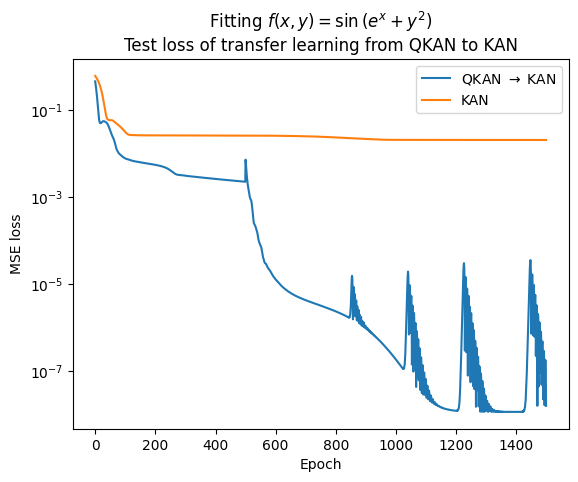

In [5]:
plt.figure()
ax = plt.subplot(111)

ax.plot(result["test_loss"], label=r"QKAN $\rightarrow$ KAN")
ax.plot(result2["test_loss"], label="KAN")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE loss")
ax.set_title(r"Fitting $f(x,y) = \sin{(e^x+y^2)}$"+ "\nTest loss of transfer learning from QKAN to KAN")
ax.set_yscale("log")

From the results, we can see that the transferred KAN achieves better performance than the pure KAN trained from scratch.

Which provides a strong support for the claim that QKAN/DARUAN or QVAF has better learning landscape than classical VAF.